In [1]:
import tensorflow as tf

if tf.test.gpu_device_name():
    print(f"GPU is available: {tf.test.gpu_device_name()}")
else:
    print("GPU not available.")

GPU not available.


## 3. Загрузка и предобработка графа

### Конвертация OWL в формат триплетов
Используем библиотеку rdflib для извлечения триплетов.

In [2]:
from rdflib import Graph

# Загрузка графа OWL
graph = Graph()
graph.parse("skyrim_knowledge_graph.owl", format="xml")

# Извлечение триплетов
triplets = []
for s, p, o in graph:
    triplets.append((str(s), str(p), str(o)))

# Сохранение триплетов в формате CSV
import pandas as pd

triplets_df = pd.DataFrame(triplets, columns=["subject", "predicate", "object"])
triplets_df.to_csv("skyrim_triplets.csv", index=False)

print(f"Extracted {len(triplets)} triplets.")

Extracted 17634 triplets.


## 4. Разбиение данных
### 4.1 Подготовка данных
Загрузим данные и удалим строки с отсутствующими значениями.

In [3]:
# Загрузка триплетов
triplets = pd.read_csv("skyrim_triplets.csv")

# Удаление null значений
triplets.dropna(inplace=True)

# Разделение на обучающую и тестовую выборки
train_cutoff = int(0.8 * len(triplets))
train_triplets = triplets.iloc[:train_cutoff]
test_triplets = triplets.iloc[train_cutoff:]

print(f"Training triplets: {len(train_triplets)}, Testing triplets: {len(test_triplets)}")

Training triplets: 14066, Testing triplets: 3517


In [4]:
triplets

,subject,predicate,object
0,http://example.org/skyrim#Fridrika,http://example.org/skyrim#locatedAt,http://example.org/skyrim#Solitude
1,http://example.org/skyrim#History_of_Raven_Roc...,http://example.org/skyrim#authoredBy,http://example.org/skyrim#Lyrin_Telleno
2,http://example.org/skyrim#Vekel_the_Man,http://example.org/skyrim#isMemberOf,http://example.org/skyrim#ServicesRiftenRagged...
3,http://example.org/skyrim#Ronthil,http://example.org/skyrim#isMemberOf,http://example.org/skyrim#DLC1VampireFaction
4,http://example.org/skyrim#Kolbjorn_Guard,http://example.org/skyrim#hasSkill,http://example.org/skyrim#Light_Armor
...,...,...,...
17629,http://example.org/skyrim#Madesi,http://example.org/skyrim#locatedAt,http://example.org/skyrim#Riften
17630,http://example.org/skyrim#Bjornolfr,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://www.w3.org/2002/07/owl#NamedIndividual
17631,http://example.org/skyrim#Stump,http://example.org/skyrim#hasRace,http://example.org/skyrim#Animals
17632,http://example.org/skyrim#Fultheim,http://example.org/skyrim#hasSkill,http://example.org/skyrim#Two-handed


## Обучение модели

In [5]:
import numpy as np

train_triplets_np = train_triplets.values
test_triplets_np = test_triplets.values

In [6]:
from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.evaluation import train_test_split_no_unseen

# Разделение данных для обучения и валидации
train, valid = train_test_split_no_unseen(train_triplets_np, test_size=0.2)

# Инициализация модели
model = ScoringBasedEmbeddingModel(scoring_type='ComplEx',  k=300, 
               eta=10)

model.compile(loss='nll', optimizer='adam')
# Обучение модели
model.fit(train,epochs=200,verbose=True)

Epoch 1/200
13/13 [==============================] - 4s 311ms/step - loss: 13000.2891
Epoch 2/200
13/13 [==============================] - 2s 129ms/step - loss: 12994.6133
Epoch 3/200
13/13 [==============================] - 2s 129ms/step - loss: 12987.7832
Epoch 4/200
13/13 [==============================] - 2s 130ms/step - loss: 12977.3828
Epoch 5/200
13/13 [==============================] - 2s 131ms/step - loss: 12960.2178
Epoch 6/200
13/13 [==============================] - 2s 129ms/step - loss: 12931.6602
Epoch 7/200
13/13 [==============================] - 2s 134ms/step - loss: 12885.6162
Epoch 8/200
13/13 [==============================] - 2s 133ms/step - loss: 12815.0234
Epoch 9/200
13/13 [==============================] - 2s 136ms/step - loss: 12713.8213
Epoch 10/200
13/13 [==============================] - 2s 134ms/step - loss: 12578.4160
Epoch 11/200
13/13 [==============================] - 2s 135ms/step - loss: 12410.4756
Epoch 12/200
13/13 [==============================] 

In [7]:
from ampligraph.evaluation import train_test_split_no_unseen

# Оценка качества
ranks = model.evaluate(valid, verbose=True, use_filter={'train': train,
                                                        'test': valid})
print("Ранговые метрики:", ranks)

283/283 [==============================] - 18s 62ms/step
Ранговые метрики: [[  64   71]
 [ 278 1325]
 [  47   72]
 ...
 [1671 3476]
 [   5    3]
 [  18    4]]


In [9]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.10
MR: 547.28
Hits@10: 0.23
Hits@3: 0.11
Hits@1: 0.04


## Clustering and embedding visualization

In [13]:
!git clone https://github.com/wyldebeast-wunderliebe/incf.countryutils.git
!cd incf.countryutils && pip install .

Cloning into 'incf.countryutils'...


Processing e:\knowlege_gr\incf.countryutils
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for incf.countryutils: filename=incf.countryutils-1.2-py3-none-any.whl size=21832 sha256=9a1c68593b2b146294a2b060845572e0710b75c9001c00eb42faa00dfc56be75
  Stored in directory: C:\Users\Даня\AppData\Local\Temp\pip-ephem-wheel-cache-f2y57wl9\wheels\31\9a\65\643af8cc85dfdf744bae777b7c529d21af12d9ef9236f541df
Successfully built incf.countryutils


You should consider upgrading via the 'e:\KNOWLEGE_GR\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from incf.countryutils import transformations
%matplotlib inline

In [14]:
# # Создаем маппинг ID к именам для удобства (например, персонажи, фракции)

id_to_name_map = {**dict(zip(train[:, 0], train[:, 0])),
                  **dict(zip(train[:, 2], train[:, 2]))}

In [15]:
id_to_name_map

{"http://example.org/skyrim#The_Woodsman's_Friend": "http://example.org/skyrim#The_Woodsman's_Friend",
 'http://example.org/skyrim#ServicesSolitudeRadiantRaiments': 'http://example.org/skyrim#ServicesSolitudeRadiantRaiments',
 'http://example.org/skyrim#Skald': 'http://example.org/skyrim#Skald',
 'http://example.org/skyrim#Eimar': 'http://example.org/skyrim#Eimar',
 'http://example.org/skyrim#Father_Of_The_Niben': 'http://example.org/skyrim#Father_Of_The_Niben',
 'http://example.org/skyrim#Falk_Firebeard': 'http://example.org/skyrim#Falk_Firebeard',
 'http://example.org/skyrim#Annekke_Crag-Jumper': 'http://example.org/skyrim#Annekke_Crag-Jumper',
 'http://example.org/skyrim#Ulfberth_War-Bear': 'http://example.org/skyrim#Ulfberth_War-Bear',
 'http://example.org/skyrim#Ulfgar_the_Unending': 'http://example.org/skyrim#Ulfgar_the_Unending',
 "http://example.org/skyrim#Jornibret's_Last_Dance": "http://example.org/skyrim#Jornibret's_Last_Dance",
 'http://example.org/skyrim#Anise': 'http://ex

In [16]:
nodes_list = []
for x in train:
    if x[1] == "http://www.w3.org/1999/02/22-rdf-syntax-ns#type" and x[2] == "http://example.org/skyrim#Character":
        nodes_list.append([x[0]])
        
nodes = np.unique(nodes_list)
nodes

array(['http://example.org/skyrim#Abelone',
       'http://example.org/skyrim#Adara',
       'http://example.org/skyrim#Adeber',
       'http://example.org/skyrim#Adelaisa_Vendicci',
       'http://example.org/skyrim#Adisla',
       'http://example.org/skyrim#Adolphus_Eritius',
       'http://example.org/skyrim#Adonato_Leotelli',
       'http://example.org/skyrim#Advard',
       'http://example.org/skyrim#Adventurer',
       'http://example.org/skyrim#Aegrothius_Goth',
       'http://example.org/skyrim#Aela_the_Huntress',
       'http://example.org/skyrim#Aeri',
       'http://example.org/skyrim#Aerin',
       'http://example.org/skyrim#Aeta',
       'http://example.org/skyrim#Afa-Saryat',
       'http://example.org/skyrim#Agent_Lorcalin',
       'http://example.org/skyrim#Agmaer',
       'http://example.org/skyrim#Agni',
       'http://example.org/skyrim#Agrippa_Fundilius',
       'http://example.org/skyrim#Agrius',
       'http://example.org/skyrim#Ahkari',
       'http://example.org

In [17]:
node_embeddings = dict(zip(nodes, model.get_embeddings(nodes)))
embeddings_2d = PCA(n_components=2).fit_transform(np.array(list(node_embeddings.values())))

In [18]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

# Кластеризация узлов с использованием K-Means
clustering_algorithm = KMeans(n_clusters=30, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(nodes, model, clustering_algorithm, mode='e')

In [19]:
from rdflib import Graph, URIRef
faction_map = {
}
is_member_of_predicate = URIRef("http://example.org/skyrim#isMemberOf")
for subject, _, obj in graph.triples((None, is_member_of_predicate, None)):
    # subject — это персонаж, obj — фракция
    faction_map[str(subject)] = str(obj)

In [21]:

# Пример функции для сопоставления узла с его фракцией или расой
def node_to_faction(node):
    # Здесь необходимо извлечь фракцию или расу из данных
    # Например, через id_to_name_map или предварительный анализ графа

    return faction_map.get(node, "Unknown")

# Создаем DataFrame
plot_df = pd.DataFrame({
    "nodes": nodes,
    "embedding1": embeddings_2d[:, 0],
    "embedding2": embeddings_2d[:, 1],
    "faction": pd.Series(nodes).apply(node_to_faction),  # Используем функцию
    "cluster": "cluster" + pd.Series(clusters).astype(str)
})

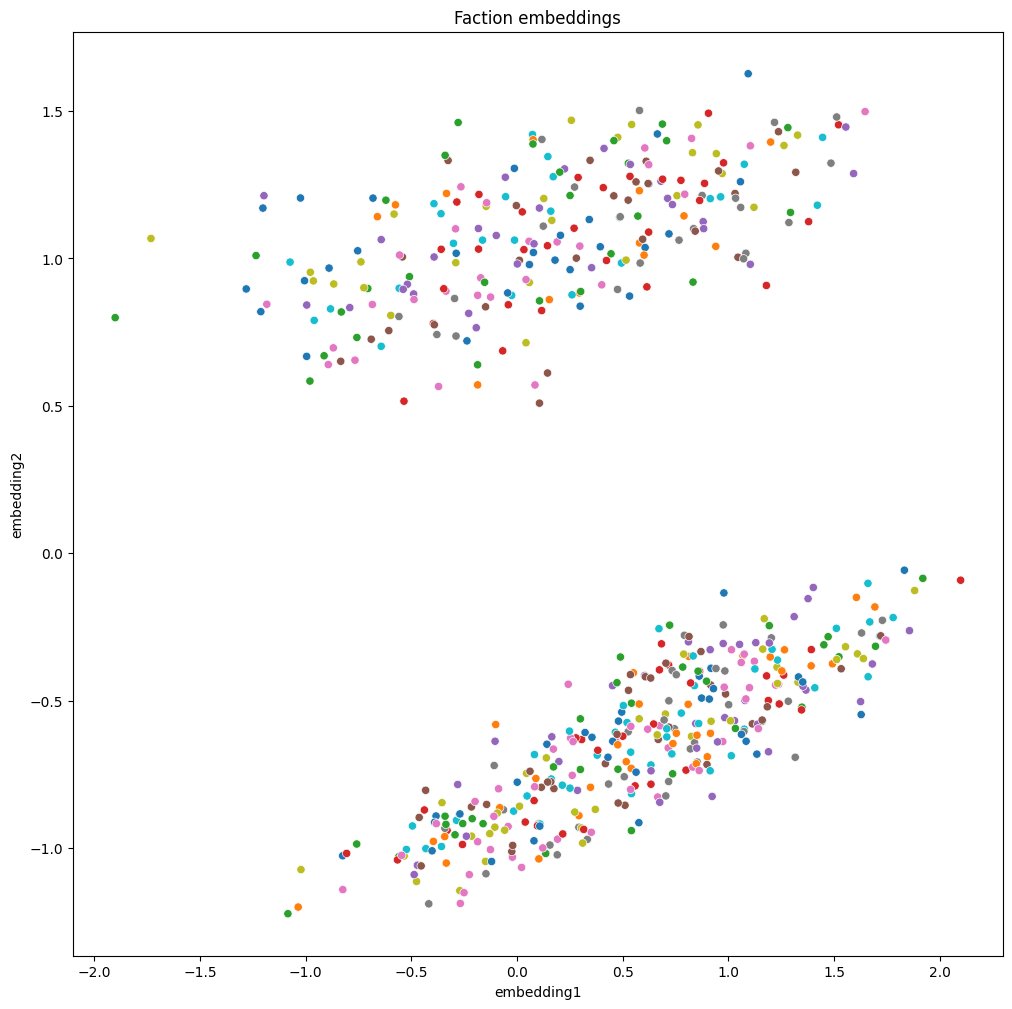

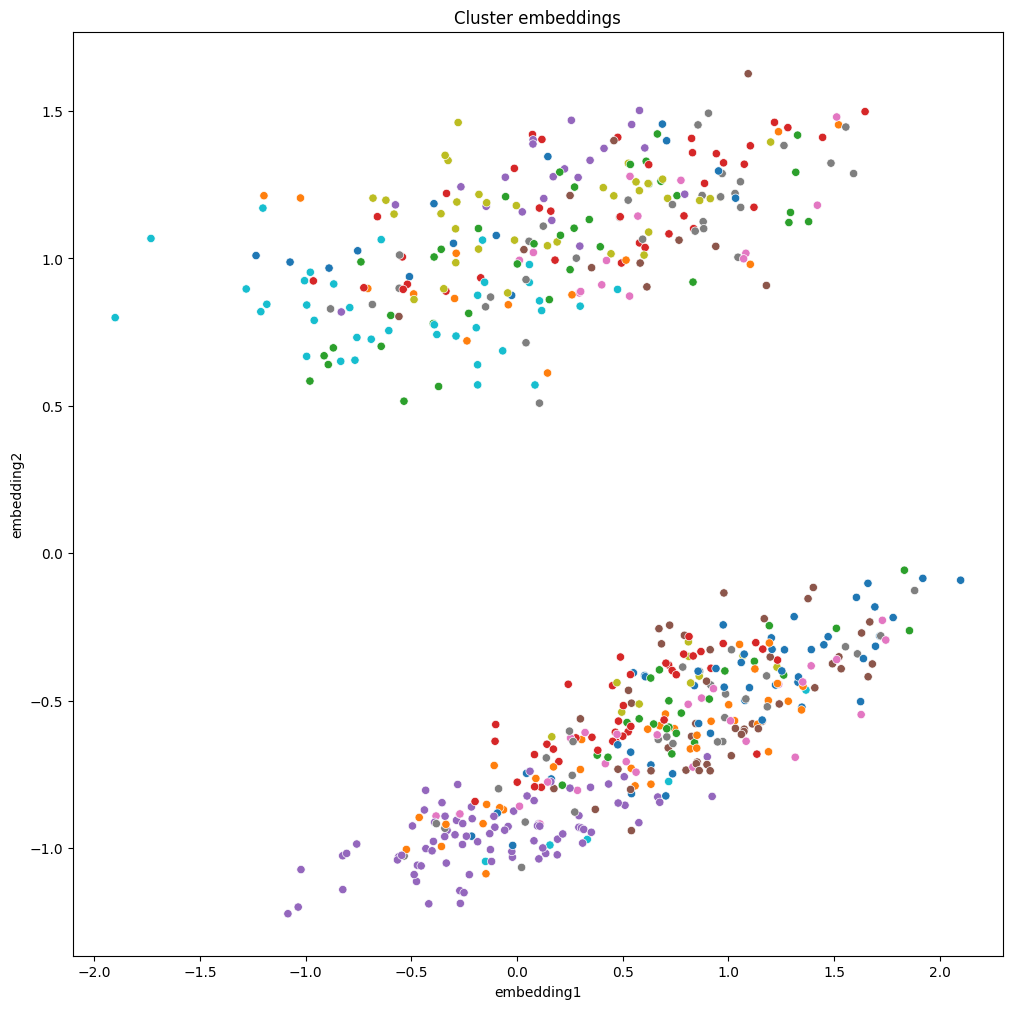

In [22]:
top20teams = ["http://example.org/skyrim#College_of_Winterhold_4(Wizard)", "http://example.org/skyrim#BardSingerInstrumentalOnlyFaction", "http://example.org/skyrim#The_Betrayed",
              "http://example.org/skyrim#The_Dark_Brotherhood", "http://example.org/skyrim#CrimeFactionGreybeard",
              "http://example.org/skyrim#DraugrFaction", "http://example.org/skyrim#BanditFaction", "http://example.org/skyrim#CompanionsCircle"]

def plot_clusters(hue):
    np.random.seed(0)
    plt.figure(figsize=(12, 12))
    plt.title("{} embeddings".format(hue).capitalize())
    ax = sns.scatterplot(data=plot_df[plot_df.faction != "Unknown"], legend=False,
                         x="embedding1", y="embedding2", hue=hue, palette="tab10")
    texts = []
    for i, point in plot_df.iterrows():
        if point["nodes"] in top20teams:  # Отображаем случайные точки для наглядности
            texts.append(plt.text(point['embedding1']+0.02, point['embedding2']+0.01, str(point["nodes"])))
    adjust_text(texts)

# Естественные кластеры (например, фракции)
plot_clusters("faction")

# Кластеры, найденные K-Means
plot_clusters("cluster")

In [23]:
from sklearn import metrics
metrics.adjusted_rand_score(plot_df.faction, plot_df.cluster)

0.35690959905985514

## Classification

Определение принадлежности к локации:

Признак: http://example.org/skyrim#locatedAt.
Цель: Предсказать локацию персонажа, основываясь на его связях в графе.

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [86]:
# Получение эмбеддингов
characters = train_triplets[train_triplets['predicate'] == 'http://example.org/skyrim#locatedAt']['subject'].unique()
locations = list(train_triplets[train_triplets['predicate'] == 'http://example.org/skyrim#locatedAt']['object'].unique())

In [89]:
character_embeddings = model.get_embeddings(characters, embedding_type='e')
labels = [locations.index(loc) for loc in train_triplets[train_triplets['predicate'] == 'http://example.org/skyrim#locatedAt']['object']]

In [91]:
# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(character_embeddings, labels, test_size=0.2)

In [94]:
# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(character_embeddings, labels, test_size=0.2)

# Обучение классификатора
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Оценка
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92        12
           1       1.00      1.00      1.00        10
           2       0.94      1.00      0.97        17
           3       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00         7
           7       1.00      1.00      1.00         3
           8       1.00      0.33      0.50         3
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         7
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      0.83      0.91         6
          15       1.00      0.75      0.86         4
          16       0.50      1.00      0.67         2
          18       0.67      0.67      0.67         3
          19       0.00      0.00      0.00         1
          20       1.00    

e:\KNOWLEGE_GR\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\KNOWLEGE_GR\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\KNOWLEGE_GR\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
